In [6]:
import sys, pathlib
import matplotlib.pyplot as plt

# Permet d'importer src/* depuis le dossier notebooks/
proj_root = pathlib.Path("..").resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))


In [7]:
from src.dataset import build_dataset
from src.config import TARGET_COL, FEATURE_COLS

df_feat = build_dataset(include_vix=True)

print("Shape:", df_feat.shape)
print("Période:", df_feat["date"].min().date(), "→", df_feat["date"].max().date())
df_feat.head()


Shape: (9267, 22)
Période: 1990-01-03 → 2025-10-23


,date,open,high,low,close,vix,ret,ret_lag1,ret_lag2,ret_lag3,...,ret_rollstd_5,ret_rollstd_10,ret_rollstd_20,abs_ret_lag1,ret_ewmstd_20,ret_z_20,range_pct,vix_lag1,close_tomorrow,y_up
0,1990-01-03,1.1333,1.1333,1.1333,1.1333,18.19,-0.007010,-0.011262,-0.001211,0.001560,...,0.006691,0.007207,0.006850,0.011262,0.006815,-1.023220,0.0,17.24,1.1585,1
1,1990-01-04,1.1585,1.1585,1.1585,1.1585,19.22,0.022236,-0.007010,-0.011262,-0.001211,...,0.012948,0.009500,0.008245,0.007010,0.009183,2.696909,0.0,18.19,1.1605,1
2,1990-01-05,1.1605,1.1605,1.1605,1.1605,20.11,0.001726,0.022236,-0.007010,-0.011262,...,0.012950,0.009364,0.008211,0.022236,0.008740,0.210252,0.0,19.22,1.1686,1
3,1990-01-08,1.1686,1.1686,1.1686,1.1686,20.26,0.006980,0.001726,0.022236,-0.007010,...,0.013134,0.009266,0.008135,0.001726,0.008417,0.857958,0.0,20.11,1.1594,0
4,1990-01-09,1.1594,1.1594,1.1594,1.1594,22.20,-0.007873,0.006980,0.001726,0.022236,...,0.012305,0.009541,0.008478,0.006980,0.008652,-0.928557,0.0,20.26,1.1609,1


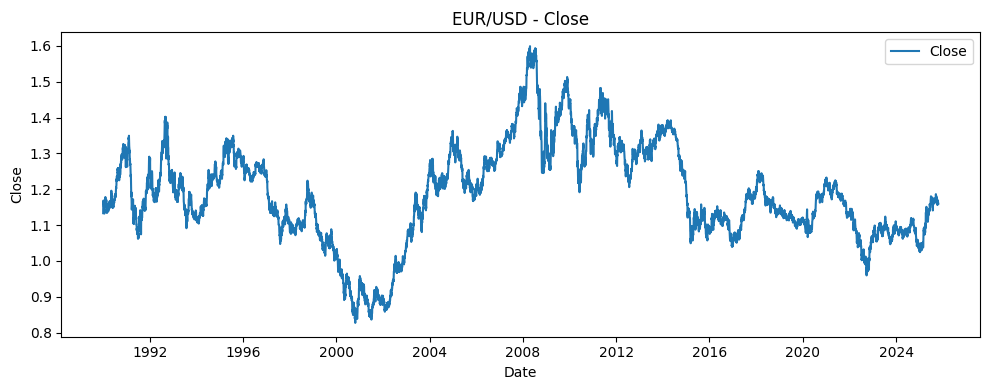

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(df_feat["date"], df_feat["close"], label="Close")
plt.title("EUR/USD - Close")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.tight_layout()
plt.show()


Return moyen: 1.9589241453278688e-05
Return std  : 0.005979836642966232


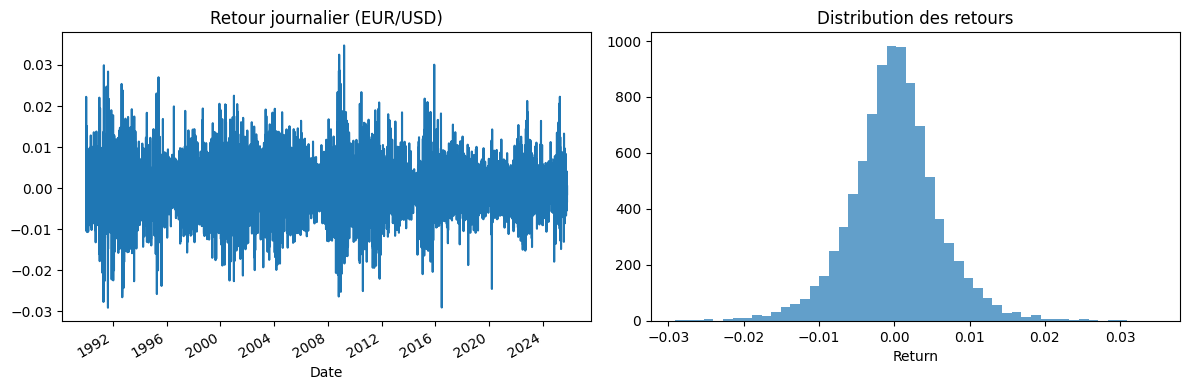

In [9]:
print("Return moyen:", df_feat["ret"].mean())
print("Return std  :", df_feat["ret"].std())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df_feat.set_index("date")["ret"].plot(ax=axes[0], title="Retour journalier (EUR/USD)")
axes[0].set_xlabel("Date")

axes[1].hist(df_feat["ret"].dropna(), bins=50, alpha=0.7)
axes[1].set_title("Distribution des retours")
axes[1].set_xlabel("Return")

plt.tight_layout()
plt.show()


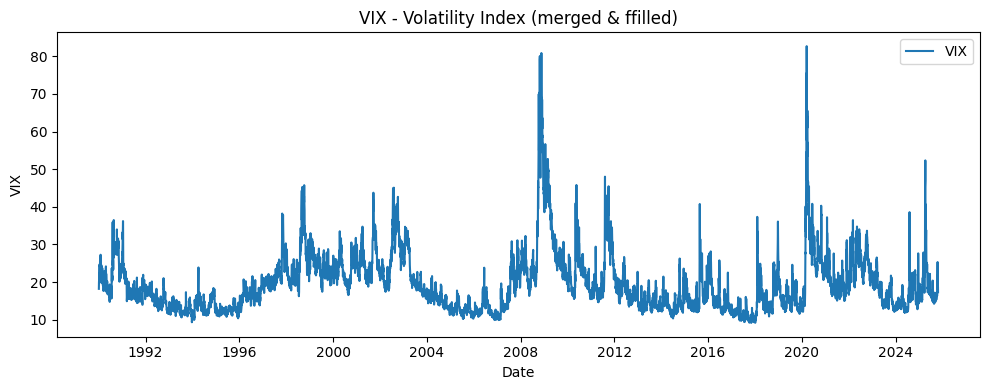

In [ ]:
if "vix" in df_feat.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(df_feat["date"], df_feat["vix"], label="VIX")
    plt.title("VIX - Volatility Index (merged & ffilled)")
    plt.xlabel("Date")
    plt.ylabel("VIX")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Colonne 'vix' absente (include_vix=False ou merge non fait).")


In [11]:
cols_show = ["date", "close"]
# on affiche uniquement celles qui existent (sécurité)
cols_show += [c for c in FEATURE_COLS if c in df_feat.columns]
cols_show += [TARGET_COL]

print("Features utilisées:", [c for c in FEATURE_COLS if c in df_feat.columns])
df_feat[cols_show].head(10)


Features utilisées: ['ret_lag1', 'ret_lag2', 'ret_lag3', 'ret_lag5', 'ret_rollmean_5', 'ret_rollstd_5', 'ret_rollstd_10', 'ret_rollstd_20', 'abs_ret_lag1', 'range_pct', 'vix_lag1']


,date,close,ret_lag1,ret_lag2,ret_lag3,ret_lag5,ret_rollmean_5,ret_rollstd_5,ret_rollstd_10,ret_rollstd_20,abs_ret_lag1,range_pct,vix_lag1,y_up
0,1990-01-03,1.1333,-0.011262,-0.001211,0.001560,0.005080,-0.002487,0.006691,0.007207,0.006850,0.011262,0.0,17.24,1
1,1990-01-04,1.1585,-0.007010,-0.011262,-0.001211,0.005490,0.000863,0.012948,0.009500,0.008245,0.007010,0.0,18.19,1
2,1990-01-05,1.1605,0.022236,-0.007010,-0.011262,0.001560,0.000896,0.012950,0.009364,0.008211,0.022236,0.0,19.22,1
3,1990-01-08,1.1686,0.001726,0.022236,-0.007010,-0.001211,0.002534,0.013134,0.009266,0.008135,0.001726,0.0,20.11,0
4,1990-01-09,1.1594,0.006980,0.001726,0.022236,-0.011262,0.003212,0.012305,0.009541,0.008478,0.006980,0.0,20.26,1
5,1990-01-10,1.1609,-0.007873,0.006980,0.001726,-0.007010,0.004873,0.011080,0.009461,0.008480,0.007873,0.0,22.20,0
6,1990-01-11,1.1594,0.001294,-0.007873,0.006980,0.022236,0.000167,0.005406,0.009361,0.007665,0.001294,0.0,22.44,1
7,1990-01-12,1.1612,-0.001292,0.001294,-0.007873,0.001726,0.000132,0.005394,0.009361,0.007577,0.001292,0.0,20.05,0
8,1990-01-16,1.1507,0.001553,-0.001292,0.001294,0.006980,-0.003072,0.005057,0.009837,0.007956,0.001553,0.0,24.64,1
9,1990-01-17,1.1537,-0.009042,0.001553,-0.001292,-0.007873,-0.000976,0.004732,0.009062,0.007796,0.009042,0.0,24.18,0


In [12]:
from src.modeling import train_test_split_time

X_train, X_test, y_train, y_test = train_test_split_time(df_feat, test_size=0.2)

print("Train size:", len(X_train), "| Test size:", len(X_test))
print("Target balance (overall):")
print(df_feat[TARGET_COL].value_counts(normalize=True).round(3))


Train size: 7413 | Test size: 1854
Target balance (overall):
y_up
1    0.502
0    0.498
Name: proportion, dtype: float64


In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Dummy: prédit toujours la classe majoritaire du train
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
pred = dummy.predict(X_test)

print("=== Dummy (most_frequent) ===")
print("Accuracy:", round(accuracy_score(y_test, pred), 3))

# Dummy stratified (renvoie des proba -> ROC-AUC possible)
dummy_s = DummyClassifier(strategy="stratified", random_state=0)
dummy_s.fit(X_train, y_train)
proba = dummy_s.predict_proba(X_test)[:, 1]
print("ROC-AUC (stratified):", round(roc_auc_score(y_test, proba), 3))


=== Dummy (most_frequent) ===
Accuracy: 0.502
ROC-AUC (stratified): 0.507


In [15]:
from src.modeling import build_logreg_pipeline
from src.evaluation import evaluate_classifier

model = build_logreg_pipeline()
model.fit(X_train, y_train)

evaluate_classifier(model, X_train, y_train, X_test, y_test, name="LogReg baseline")


=== LogReg baseline ===
Accuracy: 0.504
ROC-AUC : 0.496
Confusion matrix:
 [[334 589]
 [331 600]]

Classification report:
               precision    recall  f1-score   support

           0      0.502     0.362     0.421       923
           1      0.505     0.644     0.566       931

    accuracy                          0.504      1854
   macro avg      0.503     0.503     0.493      1854
weighted avg      0.503     0.504     0.494      1854



(0.5037756202804746, 0.4958007152225092)

“VIX is used as external risk sentiment proxy. We use only lagged VIX to avoid leakage.”